# Logistic Regression for BPSK Demodulation in Nonlinear Channels

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* demodulation of BPSK symbols in a nonlinear zero-dispersion optical transmission channel

In [1]:
import importlib
autograd_available = True
try:
    import autograd
except ImportError:
    autograd_available = False
    pass

if autograd_available:
    import autograd.numpy as np    
else:
    import numpy as np
    
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib inline 

if autograd_available:
    print('Using autograd to compute the gradient')
else:
     print('Using hand-calculated gradient')   

Using autograd to compute the gradient


Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [1] is given by an iterative application of the equation
$$
x_{k+1} = x_k\exp\left(\jmath\frac{L}{K}\gamma|x_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $x_0$ is the channel input (the modulated, complex symbols) and $x_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel Usually $K=50$ gives a good approximation.

[1] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," Proc. ECOC, Rome, Sep. 2018

In [2]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 50 # number of steps used in the channel model

def simulate_channel(x, Pin):  
    # modulate bpsk
    input_power_linear = 10**((Pin-30)/10)
    norm_factor = np.sqrt(input_power_linear);
    bpsk = (1 - 2*x) * norm_factor

    # noise variance per step    
    sigma = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    

    temp = np.array(bpsk, copy=True)
    for i in range(Kstep):
        power = np.absolute(temp)**2
        rotcoff = (L / Kstep) * gamma * power
        
        temp = temp * np.exp(1j*rotcoff) + sigma*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
    return temp

We consider BPSK transmission over this channel.

Show constellation as a function of the fiber input power. When the input power is small, the effect of the nonlinearity is small (as $\jmath\frac{L}{K}\gamma|x_k|^2 \approx 0$) and the transmission is dominated by the additive noise. If the input power becomes larger, the effect of the noise (the noise power is constant) becomes less pronounced, but the constellation rotates due to the larger input power and hence effect of the nonlinearity.

In [3]:
length = 10000

def plot_constellation(Pin):
    t = np.random.randint(2,size=length)
    r = simulate_channel(t, Pin)

    plt.figure(figsize=(6,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=True)
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='coolwarm')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title('Received constellation (L = %d km, $P_{in} = %1.2f$\,dBm)' % (L, Pin))    
    plt.savefig('bpsk_received_zd_%1.2f.pdf' % Pin,bbox_inches='tight')
    
interactive_update = interactive(plot_constellation, Pin = widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=1, continuous_update=False, description='Input Power Pin (dBm)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')))


output = interactive_update.children[-1]
output.layout.height = '500px'
interactive_update

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Input Power Pin (dBm)', lay…

Helper function to plot the constellation together with the decision region. Note that a bit is decided as "1" if $\sigma(\boldsymbol{\theta}^\mathrm{T}\boldsymbol{r}) \geq \frac12$, i.e., if $\boldsymbol{\theta}^\mathrm{T}\boldsymbol{r}\geq 0$. The decision line is therefore given by $\theta_1\Re\{r\} + \theta_2\Im\{r\} = 0$, i.e., $\Im\{r\} = -\frac{\theta_1}{\theta_2}\Re\{r\}$

In [4]:
def plot_dec(t, r, weights, title):
    ext_x = max(abs(np.real(r)))
    ext_y = max(abs(np.imag(r)))
    ext_max = max(ext_x,ext_y)*1.2

    mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
    meshgrid = np.column_stack((np.reshape(mgx,-1,1),np.reshape(mgy,-1,1)))

    decision_region = 0.2*logistic_prediction(meshgrid, weights) + 0.4

    plt.figure(figsize=(8,8))
    plt.contourf(mgx,mgy,decision_region.reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='coolwarm')

    # plot decision bound
    x_range = np.linspace(-ext_max,ext_max,100)
    plt.plot(x_range, np.clip(-weights[0]/weights[1]*x_range, -ext_max, +ext_max),'k--')
    
    plt.axis('scaled')
    plt.xlabel(r'$\Re\{r\}$',fontsize=16)
    plt.ylabel(r'$\Im\{r\}$',fontsize=16)
    plt.title(title,fontsize=16)
    plt.savefig('after_optimization.pdf',bbox_inches='tight')

Carry out gradient descent. We provide two versions of the script, one with autograd to compute automatically the gradient and one that computes the gradient manually. Here we can clearly see the benefits of automatic differentiation, avoid the need to carry out the differentiation, 

Initial loss: 6676.746914500856
Step 0  :  3734  errors with loss  6676.746914500856
Step 1000  :  19  errors with loss  192.35323947337628
Step 2000  :  19  errors with loss  127.69907686415866
Step 3000  :  19  errors with loss  104.7281567695395
Step 4000  :  19  errors with loss  92.63981990161665
Step 5000  :  19  errors with loss  85.06683025458453
Step 6000  :  18  errors with loss  79.82645679172579
Step 7000  :  18  errors with loss  75.958979019834
Step 8000  :  18  errors with loss  72.97298711962621
Step 9000  :  20  errors with loss  70.58934846686428
Trained loss: 68.6370698535443
[  47.32985792 -229.7178878 ]


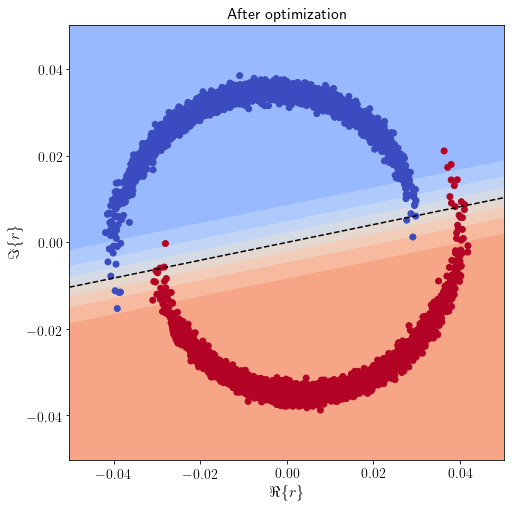

In [5]:
# set input power
Pin = 1

# sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

# derivative of the sigmoid function
def sigmoid_prime(x):
    return np.exp(-x) / ( (1+np.exp(-x))**2 )

def logistic_prediction(x, theta):
    return sigmoid(np.dot(x,theta))

def training_loss(weights):
    # Training loss is the negative log-likelihood of the training labels.
    preds = logistic_prediction(inputs, weights)
    label_probabilities = preds * t + (1 - preds) * (1 - t)
    return -np.sum(np.log(label_probabilities))


# Function that computes the gradient 'by hand', i.e., by carrying out the maths
def training_gradient_handcalculated(weights):
    preds = logistic_prediction(inputs, weights)
    denominator = preds * (2*t - 1) +  (1 - t)    
    numerator0 = sigmoid_prime(np.dot(inputs,weights)) * (2*t - 1) * inputs[:,0]
    numerator1 = sigmoid_prime(np.dot(inputs,weights)) * (2*t - 1) * inputs[:,1]
    return np.array([-np.sum(numerator0/denominator), -np.sum(numerator1/denominator)])
    
if autograd_available:
    training_gradient_fun = autograd.grad(training_loss)
else:
    training_gradient_fun = training_gradient_handcalculated    


# Build dataset
# Transmit data (bits)
t = np.random.randint(2,size=length)
# Channel output
r = simulate_channel(t, Pin)
inputs = np.column_stack((np.real(r), np.imag(r)))


weights = np.array([10.0, 0.0])
print("Initial loss:", training_loss(weights))
preds = logistic_prediction(inputs, weights) > 0.5
for i in range(10000):            
    if i % 1000 == 0:
        preds = logistic_prediction(inputs, weights) > 0.5
        errors = np.sum(preds != t)
        print('Step',i,' : ',errors,' errors with loss ',training_loss(weights))
    weights -= training_gradient_fun(weights) * 0.01
    
print("Trained loss:", training_loss(weights))

print(weights)
plot_dec(t, r, weights, 'After optimization')

[17.86771217  7.93959533]


<IPython.core.display.Javascript object>


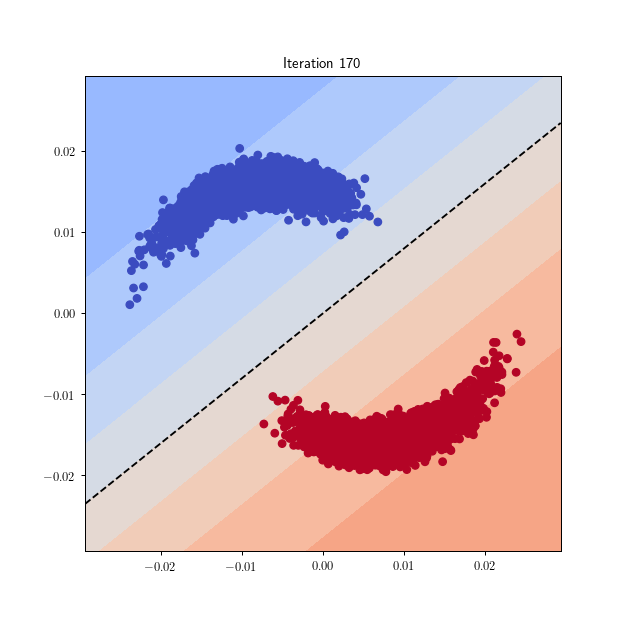

In [6]:
# Generate animation
%matplotlib notebook
%matplotlib notebook
Pin = -5
t = np.random.randint(2,size=length)
r = simulate_channel(t, Pin)
inputs = np.column_stack((np.real(r), np.imag(r)))

ext_max = max(max(abs(np.real(r))),max(abs(np.imag(r))))*1.2
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
meshgrid = np.column_stack((np.reshape(mgx,-1,1),np.reshape(mgy,-1,1)))

x_range = np.linspace(-ext_max,ext_max,100)
    
weights = 20*np.random.randn(2)
print(weights)
    
fig, ax = plt.subplots(figsize=(7,7))

ax.set_xlim(( -ext_max, ext_max))
ax.set_ylim(( -ext_max, ext_max))
ax.axis('scaled')
ax.set_xlabel(r'$\Re\{y\}$',fontsize=14)
ax.set_ylabel(r'$\Im\{y\}$',fontsize=14)

def animate(i):
    global weights
    decision_region = 0.2*logistic_prediction(meshgrid, weights) + 0.4

    decision_line = np.clip(-weights[0]/weights[1]*x_range,-ext_max,ext_max)
    
    ax.clear()
    ax.contourf(mgx,mgy,decision_region.reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
    ax.scatter(np.real(r), np.imag(r), c=t, cmap='coolwarm')
    ax.plot(x_range, decision_line,'k--')
    ax.set_title('Iteration %d' % i)
    weights -= training_gradient_fun(weights) * 0.01
    
anim = animation.FuncAnimation(fig, animate, frames=300, interval=100, blit=False)
fig.show()
#anim.save('logistic_regression.gif', writer=PillowWriter(fps=20))
